In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Technical Analysis in Python

## Creating a Candlestick Chart

### Getting ready

1. Import the libraries:

In [3]:
import pandas as pd 
import yfinance as yf

2. Download the adjusted prices from Yahoo Finance:

In [4]:
df_twtr = yf.download('TWTR',
                     start='2018-01-01',
                     end='2018-12-31',
                     progress=False,
                     auto_adjust=True)

### How to do it...

1. Import the libraries:

In [5]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode()

2. Create the candlestick chart using Twitter's stock prices:

In [6]:
qf = cf.QuantFig(df_twtr, title="Twitter's Stock Price",
                legend='top', name='TWTR')

3. Add volume and moving averages to the figure:

In [7]:
qf.add_volume()
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')

4. Display the plot:

In [8]:
qf.iplot()

## Backtesting a Strategy Based on Simple Moving Average

### How to do it...

#### Signal 

1. Import the libraries:

In [9]:
pip install backtrader

In [1]:
from datetime import datetime
import backtrader as bt

2. Define a class representing the trading strategy:

In [5]:
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

3. Download data from Yahoo Finance:

In [5]:
data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                fromdate=datetime(2018, 1, 1),
                                todate=datetime(2018, 12, 31))

4. Set up the backtest:

In [7]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

In [14]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1002.86


6. Plot the results:

<IPython.core.display.Javascript object>


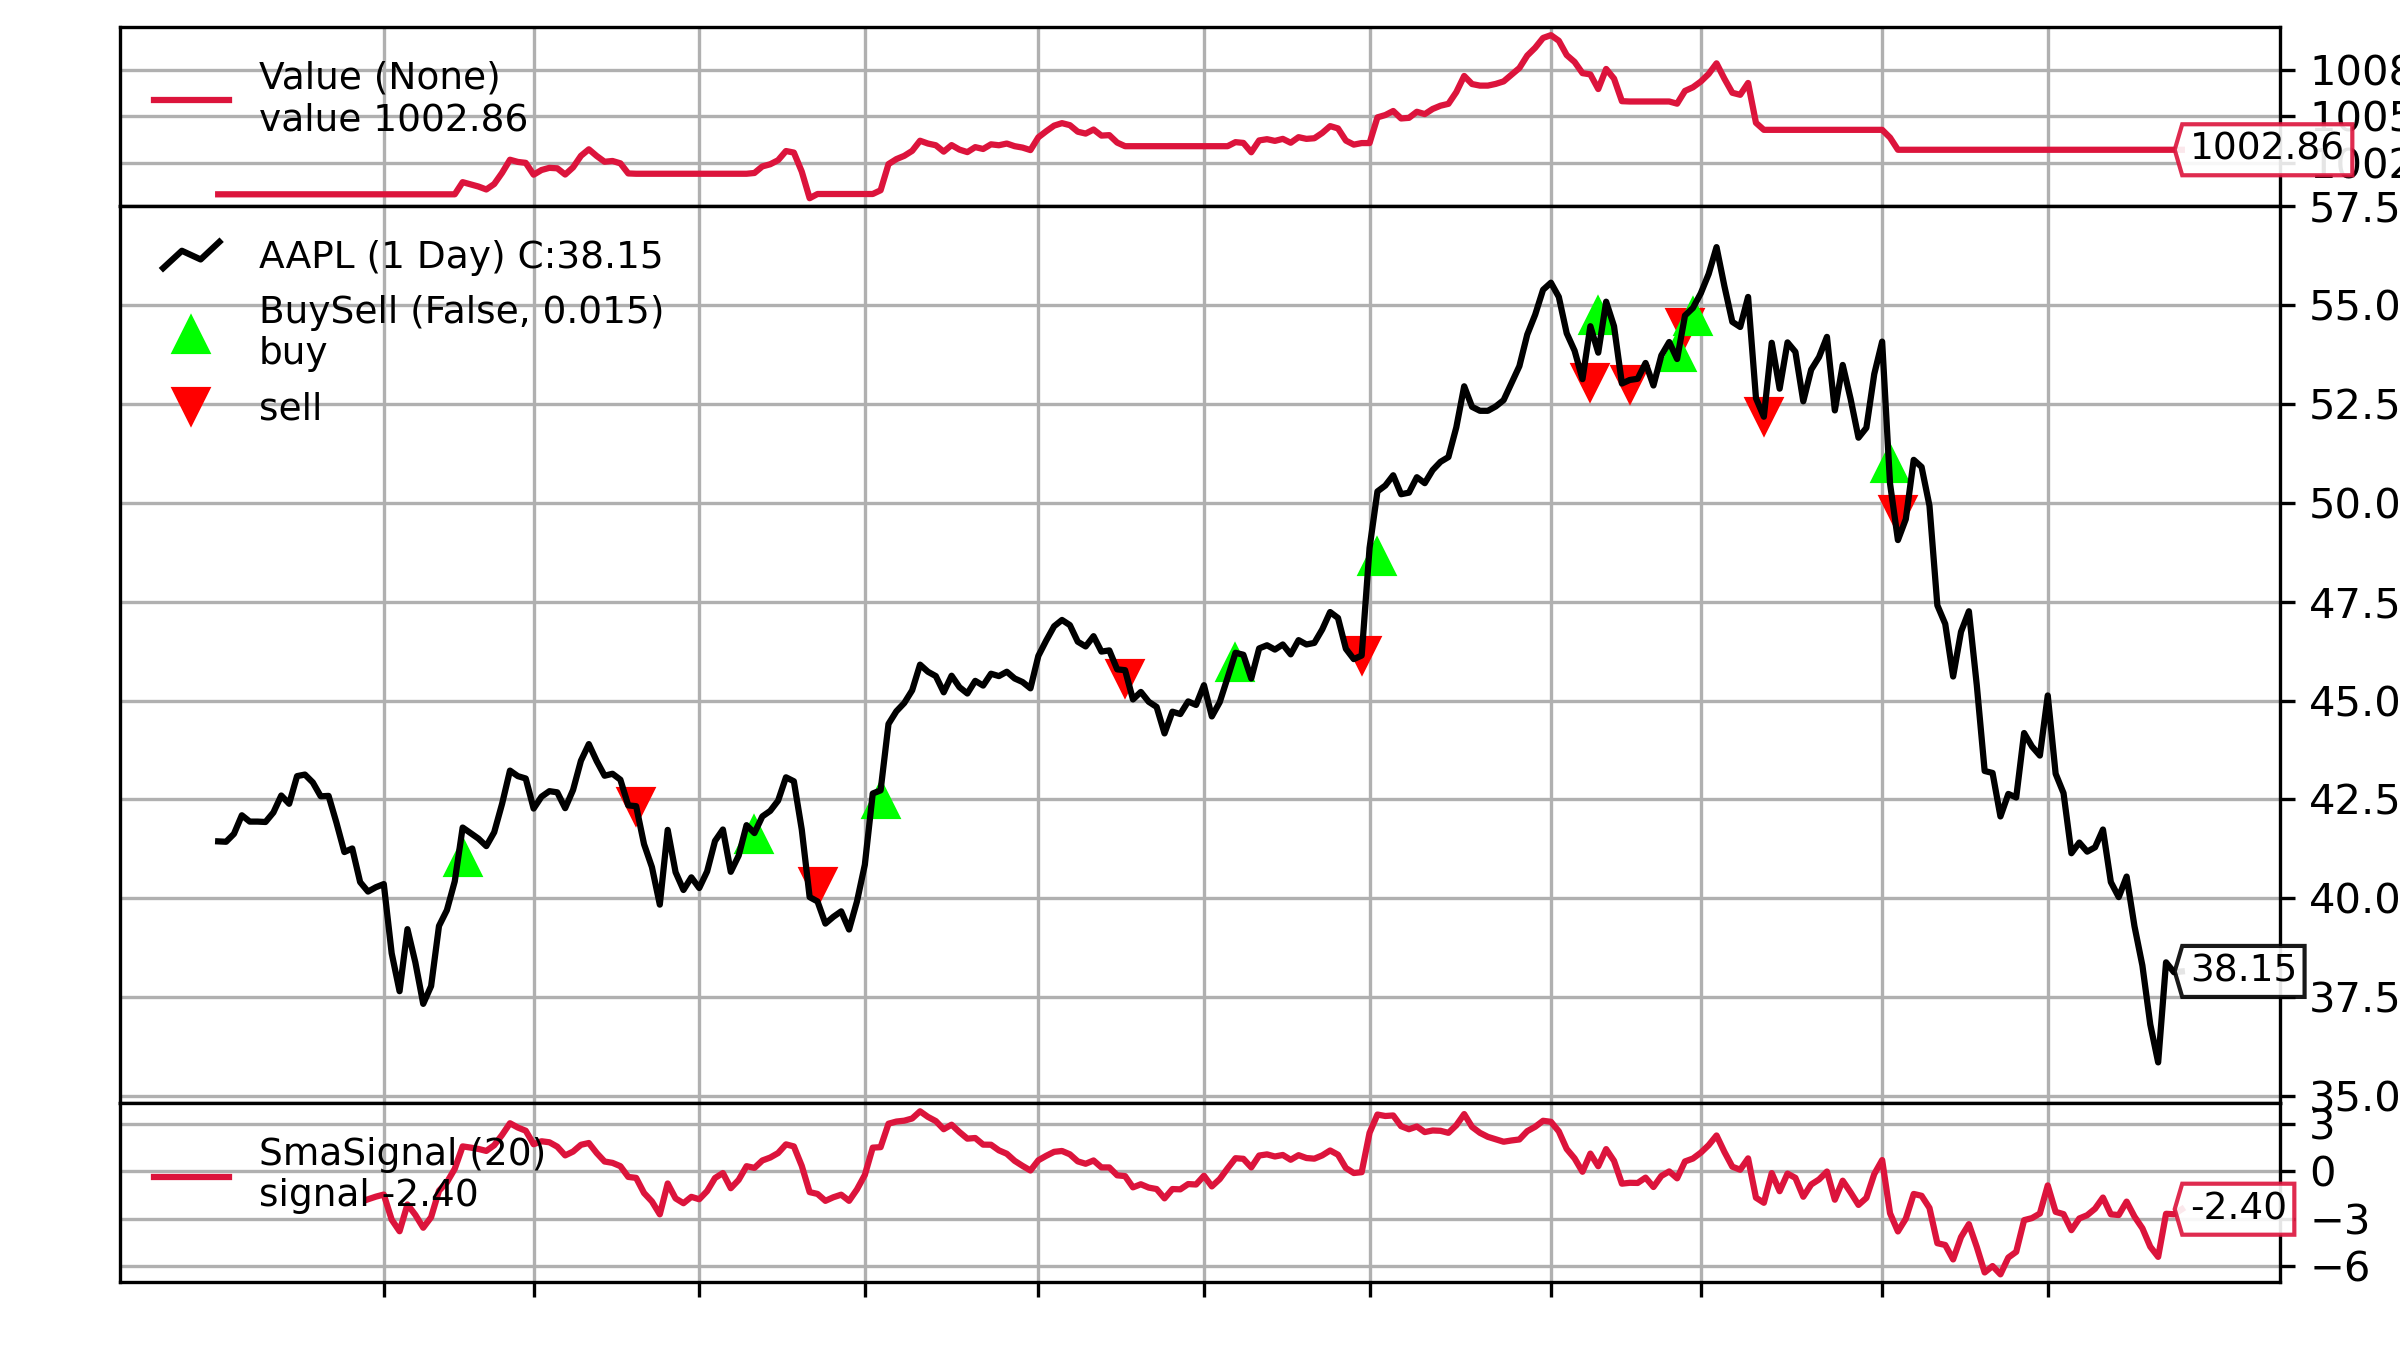

[[<Figure size 2400x1350 with 3 Axes>]]

In [17]:
cerebro.plot(iplot=True, volume=False)

#### Strategy

1. The template of the strategy looks like:

In [3]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )
    
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                             period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                             order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
        
        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
                
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

2. Set up the backtest:

In [6]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

3. Run the backtest:

In [8]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2018-02-14, BUY CREATED --- Price: 40.43
2018-02-15, BUY EXECUTED --- Price: 41.01, Cost: 41.01, Commission: 0.00
2018-03-19, SELL CREATED --- Price: 42.35
2018-03-20, OPERATION RESULT --- Gross: 1.32, Net: 1.32
2018-04-10, BUY CREATED --- Price: 41.85
2018-04-11, BUY EXECUTED --- Price: 41.60, Cost: 41.60, Commission: 0.00
2018-04-20, SELL CREATED --- Price: 40.03
2018-04-23, OPERATION RESULT --- Gross: -1.30, Net: -1.30
2018-05-02, BUY CREATED --- Price: 42.65
2018-05-03, BUY EXECUTED --- Price: 42.49, Cost: 42.49, Commission: 0.00
2018-06-15, SELL CREATED --- Price: 45.79
2018-06-18, OPERATION RESULT --- Gross: 3.07, Net: 3.07
2018-07-06, BUY CREATED --- Price: 45.58
2018-07-09, BUY EXECUTED --- Price: 45.95, Cost: 45.95, Commission: 0.00
2018-07-30, SELL CREATED --- Price: 46.05
2018-07-31, OPERATION RESULT --- Gross: 0.20, Net: 0.20
2018-08-01, BUY CREATED --- Price: 48.86
2018-08-02, BUY EXECUTED --- Price: 48.64, Cost: 48.64, Commission: 0.00
20

Plot the results:

<IPython.core.display.Javascript object>


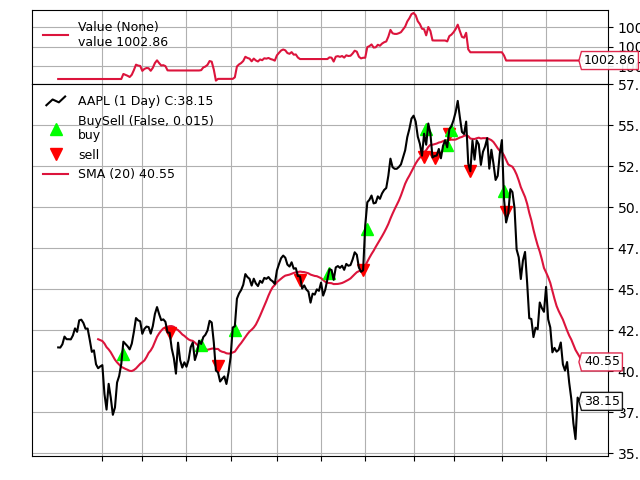

[[<Figure size 640x480 with 2 Axes>]]

In [9]:
cerebro.plot(iplot=True, volume=False)

## Calculating Bollinger Bands and testing a buy/sell strategy

1. Import the libraries

In [1]:
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt

2. The template of the strategy looks like:

In [5]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
             ('devfactor', 2.0),)
    
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
            
        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                               period=self.p.period, 
                                               devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                              self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                               self.b_band.lines.top)
            
    def log(self, txt):
        '''Logging function'''''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
                
            else:
                self.log(
                f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                             order.Rejected]:
            self.log('Order Failed')
        # set no pending order
            self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
                
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

3. Download data:

In [6]:
data = bt.feeds.YahooFinanceData(
dataname='MSFT',
fromdate=datetime.datetime(2018, 1, 1),
todate=datetime.datetime(2018, 12, 31)
)

4. Set up the backtest:

In [7]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

5. Run the backtest:

In [8]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 117, Cash: 10000.00, Open: 85.06, Close: 85.43
2018-02-12, BUY EXECUTED --- Price: 85.06, Cost: 9952.02, Commission: 9.95
2018-04-19, SELL CREATED --- Size: 117
2018-04-19, SELL EXECUTED --- Price: 92.87, Cost: 9952.02, Commission: 10.87
2018-04-19, OPERATION RESULT --- Gross: 913.77, Net: 892.95
2018-06-29, BUY CREATED --- Size: 113, Cash: 10892.95, Open: 95.68, Close: 95.37
2018-06-29, BUY EXECUTED --- Price: 95.68, Cost: 10811.84, Commission: 10.81
2018-07-17, SELL CREATED --- Size: 113
2018-07-17, SELL EXECUTED --- Price: 101.18, Cost: 10811.84, Commission: 11.43
2018-07-17, OPERATION RESULT --- Gross: 621.50, Net: 599.25
2018-10-15, BUY CREATED --- Size: 108, Cash: 11492.21, Open: 105.74, Close: 104.47
2018-10-15, BUY EXECUTED --- Price: 105.74, Cost: 11419.92, Commission: 11.42
Final Portfolio Value: 10632.99


6. Plot the results:

<IPython.core.display.Javascript object>


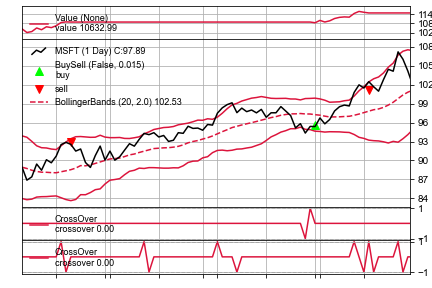

[[<Figure size 432x288 with 4 Axes>]]

In [9]:
cerebro.plot(iplot=True, volume=False)

7. Run to investigate different returns metrics:

In [10]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.06137606552952243), ('ravg', 0.0002455042621180897), ('rnorm', 0.06382092592591776), ('rnorm100', 6.382092592591776)])


8. Create a plot of daily portfolio returns:

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.Javascript object>


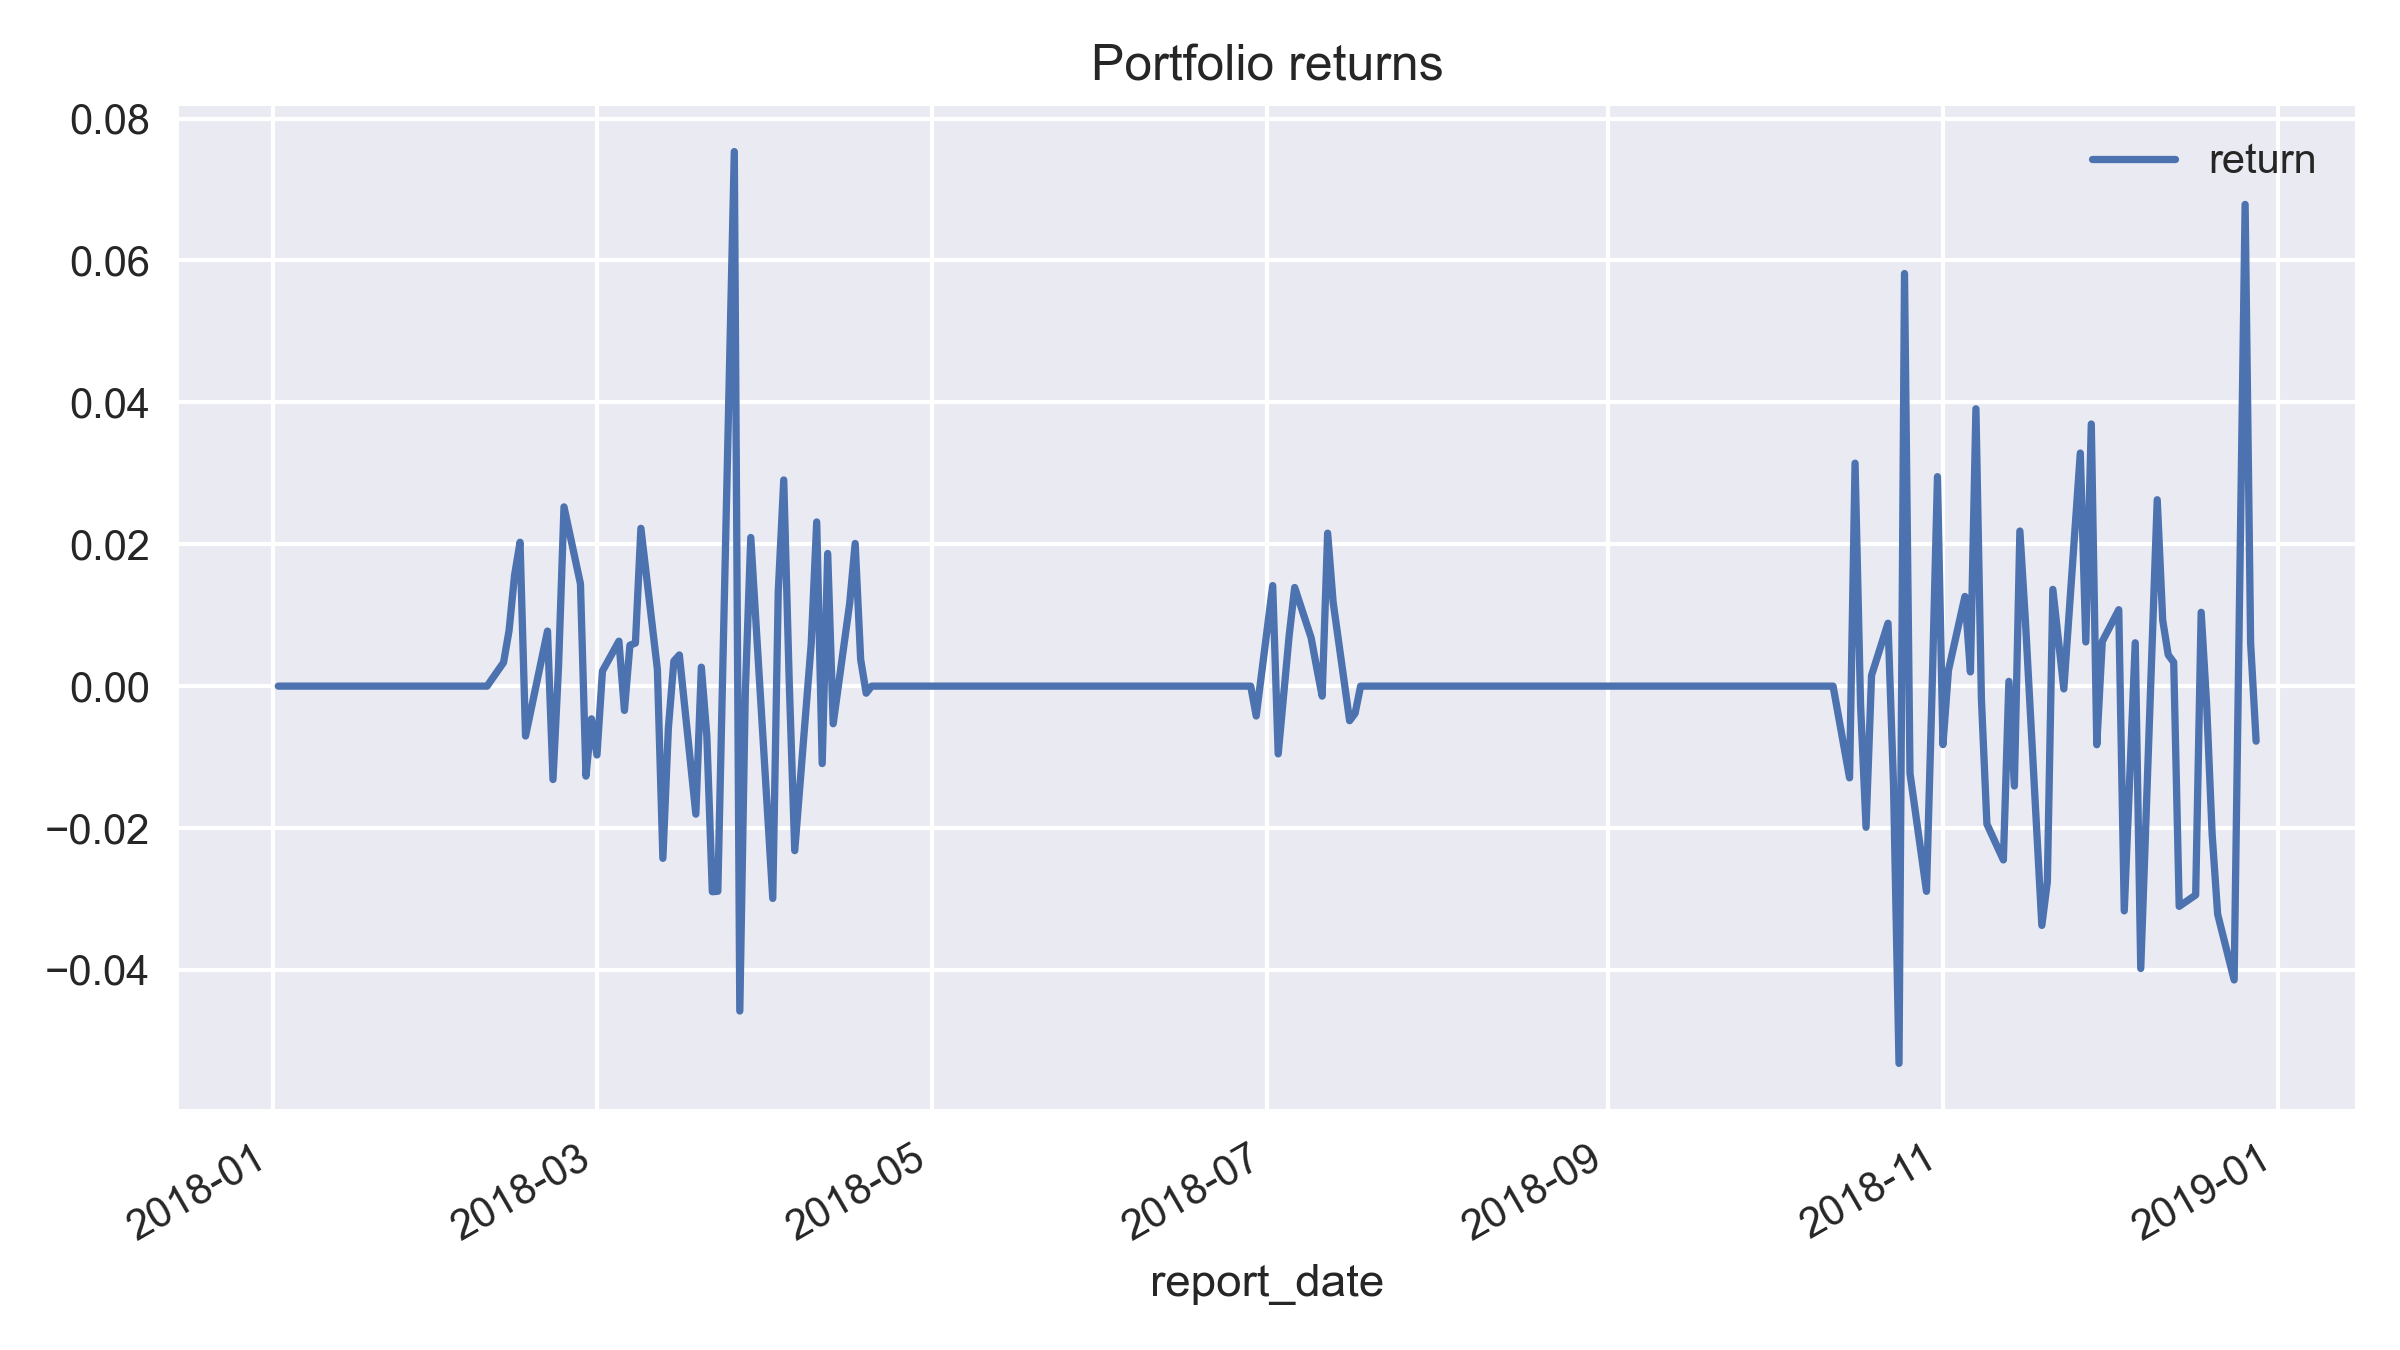

In [13]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                         columns = ['report_date', 'return']) \
.set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
plt.show()

## Calculating the relative strength index and testing a long/short strategy

1. Import the libraries:

In [6]:
from datetime import datetime
import backtrader as bt
import talib

2. Define the signal strategy based on bt.SignalStrategy:

In [7]:
# create a Stratey
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, 
                 rsi_lower=30, rsi_mid=50)
    
    def __init__(self):
        
        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                               upperband=self.p.rsi_upper,
                               lowerband=self.p.rsi_lower)
        
        # add RSI from TA-lib just for reference 
        bt.talib.RSI(self.data, plotname='TA_RSI')
        
        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))
        
        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

3. Download data:

In [8]:
data = bt.feeds.YahooFinanceData(dataname='FB', 
                                fromdate=datetime(2018, 1, 1),
                                todate=datetime(2018, 12, 31))

4. Set up and run the backtest:

In [9]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

cerebro.run()

5. Plot the results:

<IPython.core.display.Javascript object>


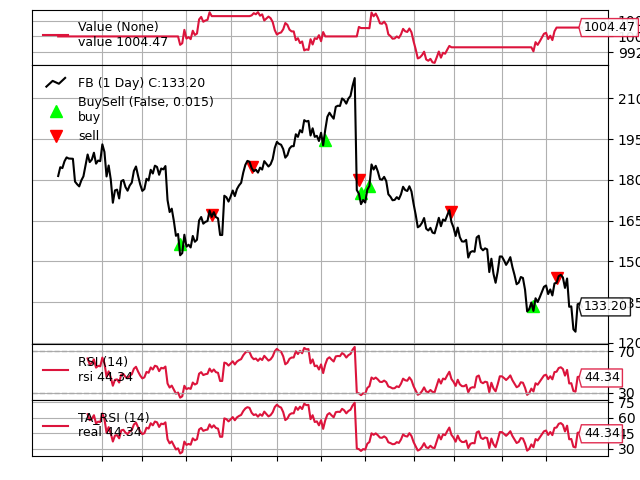

[[<Figure size 640x480 with 4 Axes>]]

In [10]:
cerebro.plot(iplot=True, volume=False)

## Building an Interactive Dashboard for Technical Analysis

1. Import the libraries:

In [1]:
pip install ipywidgets

In [1]:
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd 
import yfinance as yf
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode()

2. Define the possible values for assets and technical indicators:

In [2]:
stocks = ['TWTR', 'MSFT', 'GOOGL', 'FB', 'TSLA', 'AAPL']
indicators = ['Bollinger Bands', 'MACD', 'RSI']

3. Define a function for creating the interactive plot:

In [3]:
def ta_dashboard(asset, indicator, start_date, end_date, 
                bb_k, bb_n, macd_fast, macd_slow, macd_signal,
                rsi_periods, rsi_upper, rsi_lower):
    
    df = yf.download(asset, 
                    start=start_date, 
                    end=end_date,
                    progress=False,
                    auto_adjust=True)
    
    qf = cf.QuantFig(df, title=f'TA Dashboard - {asset}', 
                     legend='right', name=f'{asset}')
    
    if 'Bollinger Bands' in indicator: 
        qf.add_bollinger_bands(periods=bb_n,
                              boll_std=bb_k)
    if 'MACD' in indicator: 
        qf.add_macd(fast_period=macd_fast, 
                       slow_period=macd_slow, 
                       signal_period=macd_signal)
    if 'RSI' in indicator: 
        qf.add_rsi(periods=rsi_periods, 
                          rsi_upper=rsi_upper, 
                          rsi_lower=rsi_lower, 
                          showbands=True)
        
    return qf.iplot()

4. Define the selectors:

In [5]:
stocks_selector = wd.Dropdown(options=stocks,
                             value=stocks[0], 
                             description='Asset')

indicator_selector = wd.SelectMultiple(description='Indicator',
                                      options=indicators, 
                                      value=[indicators[0]])

start_date_selector = wd.DatePicker(description='Start Date', 
                                   value=pd.to_datetime('2018-01-01'), 
                                   continuous_update=False)

end_date_selector = wd.DatePicker(description='End Date', 
                                 value=pd.to_datetime('2018-12-31'), 
                                 continuous_update=False)

5. Define a label and group the selectors inside a container:

In [6]:
main_selector_label = wd.Label('Main parameters', 
                              layout=wd.Layout(height='45px'))

main_selector_box = wd.VBox(children=[main_selector_label,
                                     stocks_selector,
                                     indicator_selector,
                                     start_date_selector,
                                     end_date_selector])

6. Define the secondary selectors for Bollinger Bands:

In [7]:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                      description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                        description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

7. Define the secondary selectors for MACD:

In [8]:
macd_label = wd.Label('MACD')

macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, 
                        description='Fast avg:', 
                        continuous_update=False)

macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, 
                        description='Slow avg:', 
                        continuous_update=False)

macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, 
                          description='MACD signal:', 
                          continuous_update=False)

macd_box = wd.VBox(children=[macd_label, macd_fast, 
                            macd_slow, macd_signal])

8. Define the secondary selectors for RSI:

In [9]:
rsi_label = wd.Label('RSI')

rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, 
                          description='RSI periods:', 
                          continuous_update=False)

rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, 
                        description='Upper Thr:', 
                        continuous_update=False)

rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, 
                        description='Lower Thr:', 
                        continuous_update=False)

rsi_box = wd.VBox(children=[rsi_label, rsi_periods, 
                           rsi_upper, rsi_lower])

9. Create the labels and group the selectors into containers:

In [10]:
sec_selector_label = wd.Label('Secondary parameters', 
                             layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))

sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])

secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

10. Group the boxes and prepare the interactive output:

In [11]:
controls_dict = {'asset':stocks_selector, 
                'indicator':indicator_selector, 
                'start_date':start_date_selector, 
                'end_date':end_date_selector, 
                'bb_k':k_param, 
                'bb_n':n_param,
                'macd_fast': macd_fast, 
                'macd_slow': macd_slow, 
                'macd_signal': macd_signal,
                'rsi_periods': rsi_periods, 
                'rsi_upper': rsi_upper,
                'rsi_lower': rsi_lower}

ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

11. Display the dashboard:

In [12]:
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'application/vnd.plotly.v1+json': {'config': {'linkTe…